In [1]:
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
#path_of_lib = '/home/ksn38/spring-framework-main/'
path_of_lib = 'C:\\Users\\ksn\\frameworks\\spring-framework-main\\'
# path_of_lib = 'C:\\Users\\ksn\\frameworks\\spring-boot-main\\'

In [3]:
if os.name == "posix":
    lib = path_of_lib.split('/')[-2]
elif os.name == "nt":
    lib = path_of_lib.split('\\')[-2]

In [4]:
list_classes = []
list_classes_for_graph = []
list_classes_for_html = []
list_sizes_of_files = []
dict_sizes_of_classes = dict()
list_classes_for_html.append('<!DOCTYPE html><html><head><meta charset="utf-8"><title></title>\
<style>body{background-color: #1b232a;}div{color: #a0a0a0;}a{color: #55e1e6;}span{color: #dadada;}\
</style></head><span><i>The numbers are amount of subclasses and size of file</i></span><br><br>')

In [5]:
#open .py file and get names classes with regex
def open_and_re(path, list_classes, list_classes_for_graph, list_classes_for_html):
    with open(path, 'r', encoding='utf-8') as file:
        try:
            classes = re.findall('^class.*|^interface.*|^abstract.*|^public.*|^protected.*|^private.*', \
                                 file.read(), re.MULTILINE)
        except UnicodeDecodeError:
            classes = []
        for i in classes:
            #class is taken for graph and counter at least 4 characters in name 
            list_1_or_more_classes = re.findall('\w{4,}\.*', i)
            list_1_or_more_classes_origin = list_1_or_more_classes.copy()
            for k in list_1_or_more_classes_origin:
                if k in {'class', 'extends', 'interface', 'abstract', 'implements', 'public', \
                         'protected', 'private', 'final'}:
                    list_1_or_more_classes.remove(k)
            list_classes.extend(list_1_or_more_classes)
            if len(list_1_or_more_classes) > 0:
                dict_sizes_of_classes[list_1_or_more_classes[0]] = os.path.getsize(path)
            if len(list_1_or_more_classes) > 1:
                for j in list_1_or_more_classes[1:]:
                    list_classes_for_graph.append([list_1_or_more_classes[0], j])
        for c in classes:
            c = c.replace('<', '&lt')
            c = c.replace('>', '&gt')
            c = c.replace('{', '')
            list_classes_for_html.append(f'<div>{c}</div>')
        if len(classes) > 0:
            list_classes_for_html.append(f'<a href="{path}">{path}</a>&nbsp&nbsp&nbsp\
            <span style="color: rgb(50 ,50, blue)">{os.path.getsize(path)}</span>')
            list_sizes_of_files.append(os.path.getsize(path))

#run previous function on multiple files
def printer(tuple_from_oswalk):
    files = tuple_from_oswalk[2]
    for f in files:
        if tuple_from_oswalk[0][-1] != '/' and (f[-5:] == '.java' or f[-5:] == 'class'):
            open_and_re(tuple_from_oswalk[0] + '/' + f, list_classes, \
                        list_classes_for_graph, list_classes_for_html)
        elif tuple_from_oswalk[0][-1] == '/' and (f[-5:] == '.java' or f[-5:] == 'class'):
            open_and_re(tuple_from_oswalk[0] + f, list_classes, \
                        list_classes_for_graph, list_classes_for_html)

In [6]:
#run previous function on multiple directories
for i in os.walk(path_of_lib):
    printer(i)

class_counter = Counter(list_classes)

In [7]:
class_counter_gt_1 = {}
class_counter_lt_gt = set()
min_subclasses = 4
max_subclasses = None

for i in class_counter.items():
    if i[1] > 1:
        class_counter_gt_1[i[0]] = i[1]
    if max_subclasses == None:
        if i[1] < min_subclasses + 1:
            class_counter_lt_gt.add(i[0])
    if max_subclasses != None:
        if max_subclasses + 1 < i[1] or i[1] < min_subclasses + 1:
            class_counter_lt_gt.add(i[0])        
    
class_counter_gt_1_origin = class_counter_gt_1.copy()

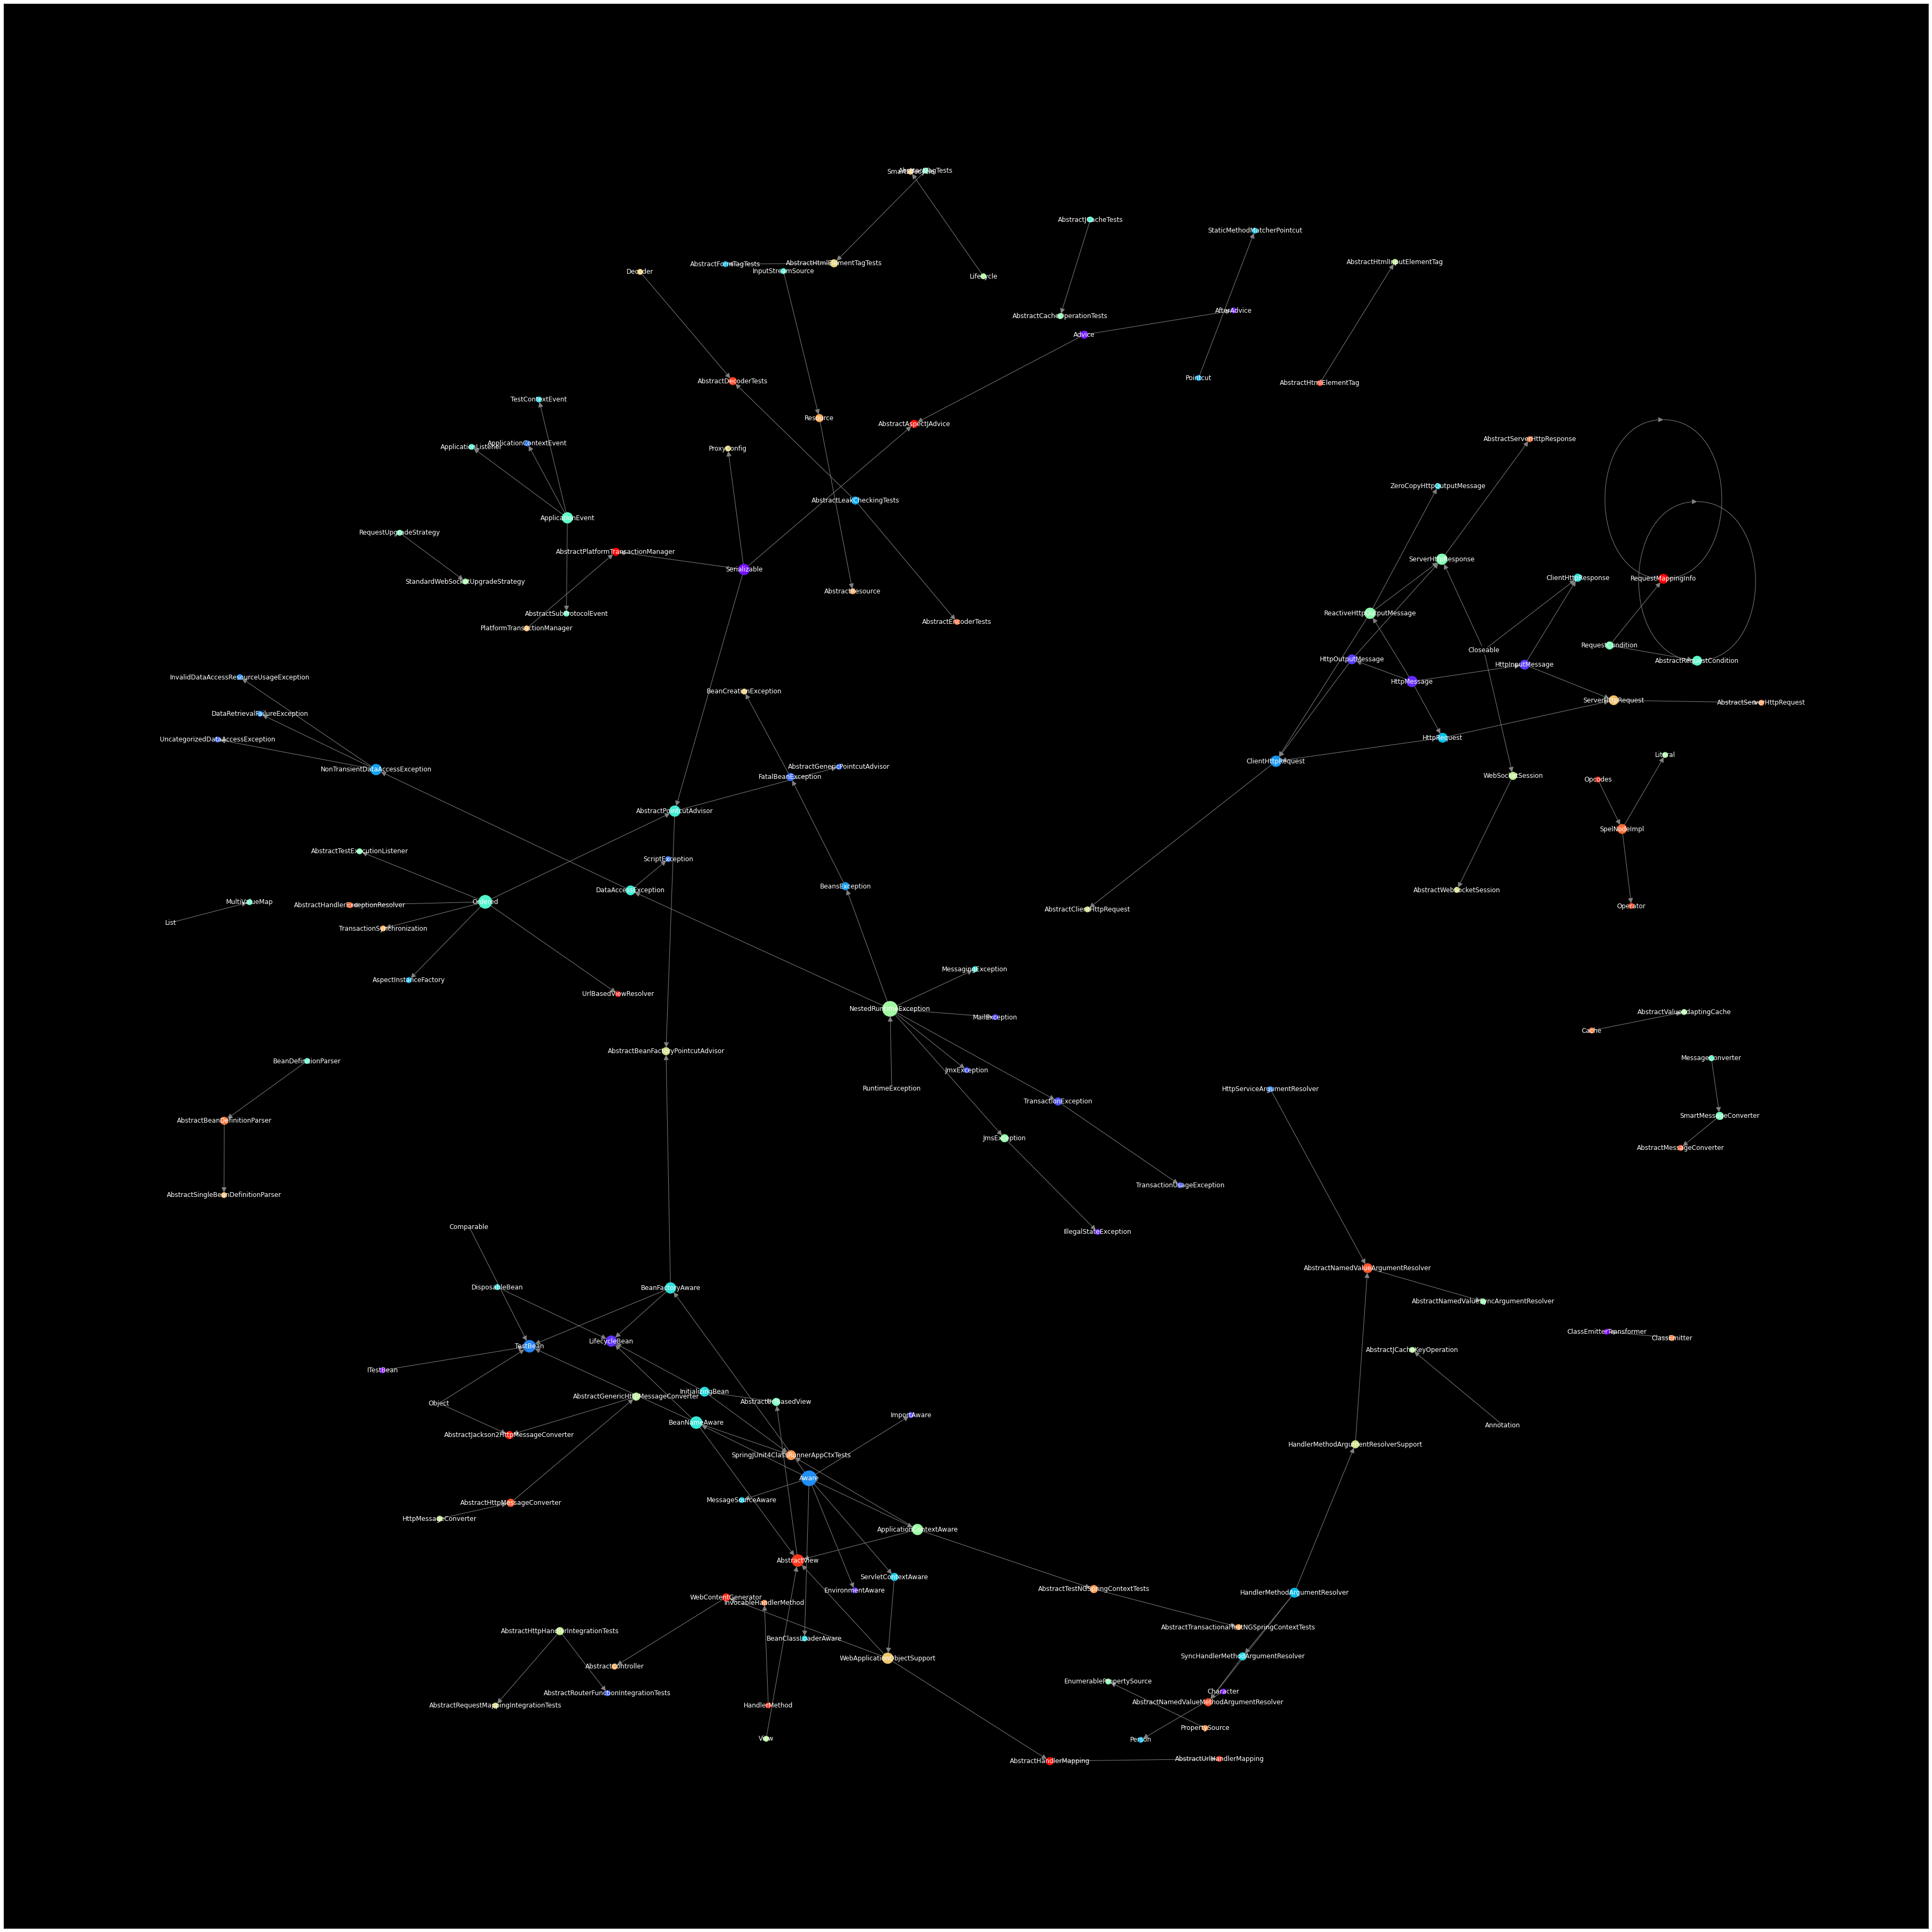

In [8]:
#create graph
size_image = 50

fig, ax = plt.subplots()
fig.set_size_inches(size_image, size_image)
fig.patch.set_visible(False)
ax.set_facecolor('k')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

DG = nx.DiGraph()
G = nx.Graph()

for i in list_classes_for_graph:
    if i[0] not in class_counter_lt_gt and i[1] not in class_counter_lt_gt:
        DG.add_edge(i[1], i[0])
        G.add_edge(i[1], i[0])

df = pd.DataFrame(list(G.degree), columns=['node','degree']).set_index('node')
df_size = pd.DataFrame({'node': list(dict_sizes_of_classes.keys()), 'size': list(dict_sizes_of_classes.values())})
df = pd.merge(df, df_size, how='left', on='node')
df['color'] = df['size'].rank()
vmin = df['color'].min()
vmax = df['color'].max()
cmap = plt.cm.rainbow

pos = nx.spring_layout(G, k=0.2, seed=38)
nx.draw_networkx(DG, pos=pos, arrows=True, arrowsize=20, node_size=df.degree*100, node_color=df['color'],\
                 edge_color='grey', font_color='white', cmap=cmap, vmin=vmin, vmax=vmax)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
#cbar = plt.colorbar(sm)
plt.savefig(f'{lib}_gt_{min_subclasses}_lt_{max_subclasses}.png')

In [9]:
list_classes_for_html.append('<br><span><b>Classes counter:</b></span><br>')
for i in sorted(class_counter_gt_1_origin.items(), key= lambda item: item[1], reverse=True):
    list_classes_for_html.append(f'<a href="#{i[0]}">{i[0]}({i[1] - 1})</a>&nbsp&nbsp')
list_classes_for_html.append('<br><br>')

In [10]:
#values of class_counter_gt_1 have been changed for convenient colors
dict_line = dict(zip(sorted(set(class_counter_gt_1.values()), reverse=True), \
                      np.linspace(0, 255, len(set(class_counter_gt_1.values())))))

for k, v in class_counter_gt_1.items():
    class_counter_gt_1[k] = dict_line[v]

In [11]:
dict_colors_for_sizes = dict(zip(sorted(list_sizes_of_files),\
                                 np.linspace(0, 255, len(list_sizes_of_files))))

In [12]:
#added colors and counter values in html
for i in range(len(list_classes_for_html)):
    size_for_color = (re.findall('ue\)">\d*', list_classes_for_html[i]))
    if len(size_for_color) > 0:
        list_classes_for_html[i] = re.sub('blue', \
                     str(dict_colors_for_sizes[int(size_for_color[0][5:])]), list_classes_for_html[i])
    try:
        c = re.findall('class\s\w+|interface\s\w+', list_classes_for_html[i])
    except:
        c = []
    if len(c) != 0:
        for j in class_counter_gt_1:
            if j == c[0].split(' ')[1]:
                list_classes_for_html[i] = '<div style="color: rgb(' + \
                str(class_counter_gt_1[j]) + ' ,255 ,' + str(class_counter_gt_1[j]) + \
                f')"  id="{j}">' + list_classes_for_html[i][5:-6] + \
                f' = {class_counter_gt_1_origin[j] - 1}</div>'

In [13]:
html_file = open(lib + '.html', 'w')
html_file.write('\n'.join(map(str, list_classes_for_html)))
html_file.close()

In [14]:
#print(sorted(class_counter_gt_1_origin.items(), key= lambda item: item[1], reverse=True))